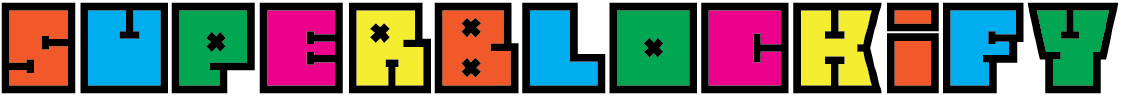

More info: [superblockify.city](https://superblockify.city)

# Superblock boundary

This notebook illustrates an example for determining the boundary polygon of a Superblock.

In [ ]:
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import shapely as shp

import superblockify as sb
from superblockify.config import logger, Config

In [ ]:
Config.PLACES_SMALL

In [ ]:
# CITY_NAME, SEARCH_STR = Config.PLACES_GENERAL[2]
CITY_NAME, SEARCH_STR = Config.PLACES_SMALL[2]
# CITY_NAME, SEARCH_STR = Config.PLACES_100_CITIES[1]

logger.info(
    "Running partitioner for %s with search string %s.", CITY_NAME, SEARCH_STR
)

part = sb.ResidentialPartitioner(
    name=CITY_NAME + "_main", city_name=CITY_NAME, search_str=SEARCH_STR
)

part.run(calculate_metrics=False, make_plots=True)

## Buffer subgraphs - concave border

In [ ]:
subgraph = part.partitions[6]["subgraph"]
subgraph_edges = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)
subgraph_edges.explore(style_kwds={"weight": 4})

In [ ]:
# From subgraph_edges we want to get a hull that encloses all edges
convex_hull = subgraph_edges.union_all().convex_hull
# Make gdf from convex hull with the same crs as the subgraph
convex_hull_gdf = gpd.GeoDataFrame(
    geometry=[convex_hull], crs=subgraph_edges.crs
)
# plot both gdfs together
ax = subgraph_edges.plot()
convex_hull_gdf.plot(ax=ax, color="lightgray")
plt.axis("off")
plt.show()

In [ ]:
subgraph_edges.boundary.plot()

In [ ]:
# Shapely MultiLineString geometry
subgraph_edges.explode().union_all().boundary


In [ ]:
# Concave hull of the edges
shp.concave_hull(
    subgraph_edges.union_all(),
    ratio=0.4,
    allow_holes=True,
)

In [ ]:
def plot_concave_hull(ax, subgraph_edges, ratio=0.4, allow_holes=False,
                      color="crimson"):
    concave_hull = shp.concave_hull(
        subgraph_edges.union_all(),
        ratio=ratio,
        allow_holes=allow_holes,
    )
    # Make gdf from convex hull with the same crs as the subgraph
    convex_hull_gdf = gpd.GeoDataFrame(
        geometry=[concave_hull], crs=subgraph_edges.crs
    )
    # plot both gdfs together
    convex_hull_gdf.plot(ax=ax, color=color)

In [ ]:
from numpy import linspace

# Figure different ratios
fig = plt.figure(layout="constrained", figsize=(10, 8))
subfigs = fig.subfigures(2, 1, hspace=0.07, height_ratios=[2., 1.])
# Overlaying
axs0 = subfigs[0].subplots(1, 1)
for ratio in linspace(1, 1 / 10, 10):
    color = plt.cm.coolwarm(ratio)
    plot_concave_hull(axs0, subgraph_edges, ratio=ratio, color=color)
subgraph_edges.plot(ax=axs0, color="black", linewidth=3)
axs0.set_axis_off()
colorbar = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm,
                                 norm=plt.Normalize(vmin=1, vmax=0.1))
# vertically oriented colorbar with title Ratio of Alpha Shape
cbar = fig.colorbar(colorbar, ax=axs0, orientation="vertical", shrink=0.8)
cbar.set_label("Ratio of Alpha Shape", rotation=270, labelpad=20)
cbar.ax.get_yaxis().labelpad = 20

# Side by side
axs1 = subfigs[1].subplots(1, 7)
for i, ratio in enumerate(linspace(1, 1 / 10, 7)):
    color = plt.cm.coolwarm(ratio)
    plot_concave_hull(axs1[i], subgraph_edges, ratio=ratio, color=color)
    subgraph_edges.plot(ax=axs1[i], color="black", linewidth=3)
    axs1[i].set_axis_off()

plt.show()

In [ ]:
# Make multilinestring from the edges
subgraph_edges_multilinestring = shp.MultiLineString(subgraph_edges.geometry.values)
subgraph_edges_multilinestring.convex_hull

In [ ]:
def border_from_subgraph(subgraph, buffer=2):
    edges = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)
    return edges.union_all().buffer(buffer, cap_style='flat').buffer(-buffer / 2)

In [ ]:
gpd.GeoDataFrame(
    geometry=[border_from_subgraph(p["subgraph"]) for p in part.partitions],
    crs=part.partitions[0]["subgraph"].graph["crs"]
).explore()

In [ ]:
# Now the same, but color every partition differently
fig, ax = plt.subplots(figsize=(10, 10))
for i, p in enumerate(part.partitions):
    border = border_from_subgraph(p["subgraph"])
    gpd.GeoDataFrame(
        geometry=[border],
        crs=p["subgraph"].graph["crs"]
    ).plot(ax=ax, color=f"C{i}")
    ax.set_title("Borders of the partitions")

plt.show()

In [ ]:
def border_from_subgraph_shrinked(subgraph, buffer=1):
    """Shrinked subgraph borders, to avoid overlap between partitions.
    Does work well with small buffer values."""
    edges = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)
    # First buffer with flat cap style to avoid self-intersections
    polygon = shp.Polygon(edges.union_all().buffer(2 * buffer, cap_style='flat')
                          .exterior)
    # Simplify the polygon to remove small artifacts of flat cap style at curved edges
    # polygon = polygon.simplify(buffer*2, preserve_topology=True)
    # Here the simple Ramer–Douglas–Peucker algorithm does not suffice our needs,
    # because the result does not inherently enclose the original polygon.
    # geos::simplify::PolygonHullSimplifier would do the job.
    # It got added in GEOS 3.11, but no python package has any bindings, yet.
    # https://libgeos.org/doxygen/classgeos_1_1simplify_1_1PolygonHullSimplifier.html
    # http://lin-ear-th-inking.blogspot.com/2022/04/outer-and-inner-concave-polygon-hulls.html
    # http://lin-ear-th-inking.blogspot.com/2022/05/using-outer-hulls-for-smoothing.html
    # Also low-res smoothing could be a solution - taking all midpoints and buffering
    # slightly

    # Second erode the polygon to avoid overlap between partitions
    return polygon.buffer(-buffer, cap_style='round')


border_from_subgraph_shrinked(part.partitions[6]["subgraph"], buffer=1)

In [ ]:
def border_from_subgraph_smoothed(subgraph, buffer=10):
    """Smoothed subgraph borders, to avoid overlap between partitions.
    Works better with larger buffer values."""
    edges = ox.graph_to_gdfs(subgraph, nodes=False, edges=True)
    # First buffer with flat cap style to avoid self-intersections
    lin_ring = edges.union_all().buffer(buffer, cap_style='flat').exterior
    # Smoothen the linear ring, taking the midpoints of the edges
    lin_ring = shp.LinearRing(
        [shp.Point((x1 + x2) / 2, (y1 + y2) / 2) for (x1, y1), (x2, y2) in zip(
            lin_ring.coords[:-1], lin_ring.coords[1:]
        )]
    )
    # Second erode the polygon to avoid overlap between partitions
    return shp.Polygon(lin_ring).buffer(-buffer / 10, cap_style='round')


border_from_subgraph_smoothed(part.partitions[6]["subgraph"], buffer=10)

## Morphological tessellation

Use borders of partitions with smaller (but positive) buffer to generate
morphological tessellation (MT). The difference to the usual usage is that we use the
borders instead of building footprints.

See Momepy
[Morphological tessellation](http://docs.momepy.org/en/stable/user_guide/elements/tessellation.html#Morphological-tessellation).

In [ ]:
import momepy as mm

In [ ]:
# Add borders to the partitions
borders = gpd.GeoDataFrame(
    geometry=[border_from_subgraph_shrinked(p["subgraph"], buffer=1) for p in part
    .partitions],
    crs=part.partitions[0]["subgraph"].graph["crs"],
    data=[p["name"] for p in part.partitions],
    columns=["partition_id"]
)
# # We do not want overlap between the partitions, so we
# borders = borders.dissolve(by="partition_id")
# gpd.GeoDataFrame(geometry=borders.geometry, crs=borders.crs).explore(column="partition_id")

In [ ]:
# Get the graphs boundary polygon
part.graph.graph["boundary"]

### Morphological tessellation

Basically doing Voronoi cells for the whole graph and grouping them by the
borders/partitions. Using the whole graph.

In [ ]:
# Morphological tessellation around given buildings ``gdf`` within set ``limit``.
t0 = datetime.now()
tessellation = mm.Tessellation(borders, unique_id="partition_id",
                               limit=part.graph.graph["boundary"],
                               shrink=0.0)
time_full_tess = datetime.now() - t0

In [ ]:
tessellation_gdf = tessellation.tessellation
fig, axe = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=axe, edgecolor="white", column="partition_id", legend=True,
                      cmap="tab20")
borders.plot(ax=axe, color="white", alpha=0.5, facecolor="white")
ox.plot_graph(part.sparsified, ax=axe, node_size=0, edge_color="black",
              edge_linewidth=1)
axe.set_axis_off()
plt.show()

### Enclosed tessellation

Enclosed tessellation is a special case of morphological tessellation. It is
based on the same principle, but it is done for each enclosure separately. Enclosure
is a polygonal area enclosed by primary barriers (e.g. roads). Enclosed tessellation
is useful for example for analysis of building plots. As the enclosures can be
handled separately, this approach is more efficient.
In our case we know that the sparsified network functions as barrier for Superblocks, so we
create enclosures (polygonize) from it first.

In [ ]:
# Enclosed tessellation based on given buildings ``gdf`` within ``enclosures``.
edges_sparsified = ox.graph_to_gdfs(part.sparsified, nodes=False, edges=True,
                                    node_geometry=False)
enclosures = mm.enclosures(
    primary_barriers=gpd.GeoDataFrame(
        geometry=part.graph.graph["boundary"].difference(
            gpd.GeoSeries(edges_sparsified.buffer(5)
                          .union_all())),
        crs=part.graph.graph["boundary_crs"]
    ),
    limit=  #mm.buffered_limit(borders, 1).convex_hull,
    gpd.GeoSeries(
        [part.graph.graph["boundary"]],
        crs=part.graph.graph["boundary_crs"]
    ),
    enclosure_id="eID",
)
enclosures.explore(column="eID")

Note the big enclosure around the whole graph. This is because the simplified network
does not reach to the boundary of the graph, so it is contained in one. But other
polygons are contained inside.

In [ ]:
t0 = datetime.now()
tessellation = mm.Tessellation(borders, unique_id="partition_id",
                               enclosures=enclosures, enclosure_id="eID",
                               use_dask=False)
time_enclosed_tess = datetime.now() - t0

In [ ]:
tessellation_gdf = tessellation.tessellation

In [ ]:
fig, axe = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=axe, edgecolor="white", column="partition_id", legend=True,
                      cmap="tab20")
borders.plot(ax=axe, color="white", alpha=0.5, facecolor="white")
ox.plot_graph(part.graph, ax=axe, node_size=0, edge_color="black", edge_linewidth=0.5)
axe.set_axis_off()
plt.show()

The enclosed tesselation takes less time, and the tesselation cells are cleaner, for
the enclosed areas. The execution times are:

In [ ]:
print(f"Full tessellation: {time_full_tess}")
print(f"Enclosed tessellation: {time_enclosed_tess}")
print(f"Enclosed tessellation is {time_full_tess / time_enclosed_tess} times faster.")

For bigger graphs the difference is expected to be larger.

## Independent tessellation

When looking into the code, `momepy` uses `scipy.spatial.Voronoi` to generate the
tessellation for every enclosure. This is done with a dense point array for the
geometry boundaries (borders in our case).

As we want to calculate area and population for each Partition, we can save time by
calculating the Voronoi diagram once for the whole graph/city (to keep it light only
for nodes), and save `area` and `population` for each note. Later we can use this data
to calculate the area and population for each Partition.

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d

### Nodes

In [ ]:
nodes = ox.graph_to_gdfs(part.graph, nodes=True, edges=False)
nodes.explore(column="street_count")

In [ ]:
nodes

In [ ]:
# get numpy array with x, y coordinates of the nodes
node_points = nodes[["x", "y"]].to_numpy()
node_points

In [ ]:
node_voronoi_diagram = Voronoi(node_points)
fig = voronoi_plot_2d(node_voronoi_diagram, show_vertices=False, line_colors='orange',
                      line_width=2, line_alpha=0.6, point_size=2)
plt.show()

In [ ]:
# Construct cell polygons for each node
node_vertices = pd.Series(node_voronoi_diagram.regions).take(
    node_voronoi_diagram.point_region)
node_polygons = []
for region in node_vertices:
    if -1 not in region:
        node_polygons.append(
            shp.polygons(node_voronoi_diagram.vertices[region]).intersection(
                part.graph.graph["boundary"]))
    else:
        node_polygons.append(None)

node_polygons

In [ ]:
# Create GeoDataFrame with the polygons
node_poly_gdf = gpd.GeoDataFrame(geometry=node_polygons,
                                 crs=part.graph.graph["boundary_crs"],
                                 index=nodes.index)
# get street_count column from nodes
node_poly_gdf["street_count"] = nodes["street_count"]
# plot with street_count as color with colormap
fig, axe = plt.subplots(figsize=(10, 10))
node_poly_gdf.plot(column="street_count", ax=axe, legend=True)
ox.plot_graph(part.graph, ax=axe, node_size=8, edge_color="white", edge_linewidth=0.5,
              node_color="white")
# poly_gdf.explore(column="street_count")

Now show which partition they would make with the Partitioner `part`.

In [ ]:
# Add cell polygon to the graph for each node
for node in part.graph.nodes:
    part.graph.nodes[node]["cell"] = node_poly_gdf.loc[node, "geometry"]
# For each partition create boundary as union of cells
for p, p_order in zip(part.partitions, part.get_partition_nodes()):
    p["boundary"] = shp.union_all()(
        [part.graph.nodes[node]["cell"] for node in p_order["nodes"]])

In [ ]:
gpd.GeoDataFrame(
    geometry=[p["boundary"] for p in part.partitions],
    crs=part.graph.graph["boundary_crs"],
    data=[p["name"] for p in part.partitions],
    columns=["partition_id"]
).explore(column="partition_id")

These cells are a bit too rough, but we can make them smoother by creating the
Voronoi diagram with a dense point array, like the Momepy Tessellation does.

### Edges

Also, let's depart from the nodes and use the edges instead. This way we also dodge
the intricacy that nodes are shared between partitions, edges are not.

In [ ]:
edges = ox.graph_to_gdfs(part.graph,
                         nodes=False,
                         edges=True,
                         node_geometry=False,
                         fill_edge_geometry=True)
# `edges` is a pandas dataframe with the multiindex (u, v, key)
# Merge two columns, when the geometry of one is equal or the reverse of the other
# 1. Group if u==u and v==v or u==v and v==u (match for hashed index (u, v) where u<v)
# get flat index of the first match
edges["edge_id"] = edges.index.to_flat_index()
# sort the edge_id tuples
edges["node_pair"] = edges["edge_id"].apply(lambda x: tuple(sorted(x[:2])))
# 2. Aggregate if the geometry is equal or the reverse of the other
# Merge columns if geometry_1 == geometry_2 or geometry_1 == geometry_2.reverse()
# reverse geometry if x_start >= x_end
edges["geometry"] = edges["geometry"].apply(
    lambda x: x if x.coords[0] < x.coords[-1] else x.reverse())
# 3. Group by node_pair and geometry
edges = edges.groupby(["node_pair", "geometry"]).agg({
    "edge_id": tuple,
    "component_name": "first",
}).reset_index()
edges.set_index("edge_id", inplace=True)

# If length == 0, take the length from the geometry
# edges["length"] = edges["length"].where(edges["length"] > 0, edges["geometry"].length)
# edges["length"] = edges["geometry"].length

# Offset the geometry randomly by 5 meters
# edges["geometry"] = edges["geometry"].apply(
#     lambda x: shp.affinity.translate(x, xoff=np.random.uniform(-5, 5), yoff=np.random.uniform(-5, 5)))

edges = gpd.GeoDataFrame(edges, geometry="geometry", crs=part.graph.graph["crs"])
edges.explore()

Now we will create an array of points along the edges,

In [ ]:
distance = 10
# The maximum distance between points after discretization.
edge_points = []
edge_indices = []
# iterate over street_id, geometry
for idx, geometry in edges["geometry"].items():
    if geometry.length < 2 * distance:
        # for edges that would result in no point, take the middle
        pts = [shp.line_interpolate_point(geometry, 0.5, normalized=True)]
    else:
        # interpolate points along the line with at least distance between them
        # start and end 0.1 from the ends to avoid edge effects
        pts = shp.line_interpolate_point(
            geometry,
            np.linspace(
                0.1,
                geometry.length - 0.1,
                num=int((geometry.length - 0.1) // distance),
            ),
        )  # offset to keep nodes out
    edge_points.append(shp.get_coordinates(pts))
    # Append multiindices for this geometry
    edge_indices += [idx] * len(pts)

points = np.vstack(edge_points)

points

In [ ]:
gpd.GeoDataFrame(geometry=[shp.Point(p) for p in points],
                 crs=part.graph.graph["crs"]).plot(markersize=0.5)

Now we know for each point, which edge it belongs to. We can use this to calculate the
Voronoi diagram.

Before we continue, let's also introduce a hull around the points, so that the outer
edge cells are not infinite or too large. As a hull we can use the boundary polygon
of the graph from OSM, as used in the node approach, or a buffered union of the edge
geometries. Then we can also split up the hull into points and add them to the points
array.

In [ ]:
# get hull from the graph boundary
# hull = part.graph.graph["boundary"]
hull = shp.Polygon(edges.union_all().buffer(100).exterior)
hull

In [ ]:
# interpolate points along the hull - double the distance
hull_points = shp.line_interpolate_point(
    hull.boundary,
    np.linspace(0.1, hull.length - 0.1, num=int(hull.length // (2 * distance))),
)
# add hull points to the points array
points = np.vstack([points, shp.get_coordinates(hull_points)])
# add edge indices to the edge_indices array
edge_indices += [-1] * len(hull_points)

In [ ]:
edge_voronoi_diagram = Voronoi(points)

In [ ]:
from matplotlib.patches import Rectangle, ConnectionPatch

# Plot with inset axes
fig, axe = plt.subplots(figsize=(10, 10))
zoom_window = (587000, 587500, 5772000, 5772500)

edges.plot(ax=axe, color="black", linewidth=0.5)
voronoi_plot_2d(edge_voronoi_diagram, ax=axe, show_vertices=False, line_colors='orange',
                line_width=1, line_alpha=0.6, point_size=2)
axe.set_title("Voronoi diagram of dense edge points")
# Create inset axes
axins = axe.inset_axes([0.6, 0.01, 0.45, 0.45])
edges.plot(ax=axins, color="black", linewidth=2)
voronoi_plot_2d(edge_voronoi_diagram, ax=axins, show_vertices=False,
                line_colors='orange',
                line_width=2, line_alpha=0.6, point_size=4)
axins.set_xlim(*zoom_window[:2])
axins.set_ylim(*zoom_window[2:])
axins.set_xticks([])
axins.set_yticks([])
# Indicate zoom window
rect = Rectangle((zoom_window[0], zoom_window[2]), zoom_window[1] - zoom_window[0],
                 zoom_window[3] - zoom_window[2], linewidth=1, edgecolor='r',
                 facecolor='none', zorder=10)
axe.add_patch(rect)
# Connect zoom window to inset
axe.add_artist(
    ConnectionPatch(xyA=(zoom_window[0], zoom_window[2]),
                    xyB=(zoom_window[0], zoom_window[2]),
                    coordsA="data", coordsB="data", axesA=axe, axesB=axins,
                    linewidth=1, zorder=10))
axe.add_artist(
    ConnectionPatch(xyA=(zoom_window[1], zoom_window[3]),
                    xyB=(zoom_window[1], zoom_window[3]),
                    coordsA="data", coordsB="data", axesA=axe, axesB=axins,
                    linewidth=1, zorder=10))
plt.show()

Let's see how the cells look like for the Partitioner `part`.

In [ ]:
# Construct cell polygons for each of the dense points
point_vertices = pd.Series(edge_voronoi_diagram.regions).take(
    edge_voronoi_diagram.point_region)
point_polygons = []
for region in point_vertices:
    if -1 not in region:
        point_polygons.append(
            shp.polygons(edge_voronoi_diagram.vertices[region]))
    else:
        point_polygons.append(None)

# Create GeoDataFrame with cells and index
edge_poly_gdf = gpd.GeoDataFrame(
    geometry=point_polygons,
    index=edge_indices,
    crs=part.graph.graph["boundary_crs"],
)
# Drop cells that are outside the boundary
edge_poly_gdf = edge_poly_gdf.loc[edge_poly_gdf.index != -1]
# Dissolve cells by index
edge_poly_gdf = edge_poly_gdf.dissolve(by=edge_poly_gdf.index)
# delete index_str
edge_poly_gdf

In [ ]:
edges

In [ ]:
# bearing_90, component_name, residential, length
edge_poly_gdf["component_name"] = edges.loc[edge_poly_gdf.index, "component_name"]
# Set NaNs to "sparse"
edge_poly_gdf["component_name"] = edge_poly_gdf["component_name"].fillna("sparse")
# Plot with color by edge label
fig, axe = plt.subplots(figsize=(10, 10))
edge_poly_gdf.plot(column="component_name", ax=axe, legend=True, cmap="tab20")
ox.plot_graph(part.graph, ax=axe, node_size=8, edge_color="black", edge_linewidth=0.5,
              node_color="black")

In [ ]:
edge_poly_gdf.explore(column="component_name", cmap="tab20")

Much better!

In [ ]:
# Interactive explore map with unions of partitions
edge_poly_gdf.dissolve(by="component_name", as_index=False).explore(
    column="component_name", cmap="tab20")

In [ ]:
edges

In [ ]:
# Write edge attribute to graph
for edge_keys, polygon in edge_poly_gdf.geometry.items():
    for edge_key in edge_keys:
        part.graph.edges[edge_key]["cell"] = polygon

### Implementation

For this we implemented the `add_edge_cells` method to the `population` submodule.

Get some bigger graph from OSM.

In [ ]:
ky_graph = ox.graph_from_place("Kyiv, Ukraine", network_type="drive")
# graph = ox.graph_from_place("Scheveningen, The Hague, Netherlands", network_type="drive")
ky_graph = ox.project_graph(ky_graph)

In [ ]:
sb.add_edge_cells(ky_graph, show_plot=True)

In [ ]:
# Get polygons from edges and plot
edge_poly_gdf = gpd.GeoDataFrame(
    geometry=[data["cell"] for _, _, data in ky_graph.edges(data=True)],
    crs=ky_graph.graph["crs"],
    index=ky_graph.edges(),
    columns=["geometry"],
)
fig, axe = plt.subplots(figsize=(10, 10))
edge_poly_gdf.plot(ax=axe, color="orange", alpha=0.5, edgecolor="black", linewidth=0.5)
ox.plot_graph(ky_graph, ax=axe, node_size=0, edge_color="black", edge_linewidth=0.5,
              node_color="black")
# edge_poly_gdf.explore()